## Project Overview

Customer satisfaction drives business success and data analytics provides insight into what customers think. For example, the phrase "[360-degree customer view](https://searchsalesforce.techtarget.com/definition/360-degree-customer-view)" refers to aggregating data describing a customer's purchases and customer service interactions. 

The Starbucks Udacity Data Scientist Nanodegree Capstone challenge data set is a simulation of customer behavior on the Starbucks rewards mobile application. Periodically, Starbucks sends offers to users that may be an advertisement, discount, or buy one get one free (BOGO). An important characteristic regarding this dataset is that not all users receive the same offer.

This data set contains three files. The first file describes the characteristics of each offer, including its duration and the amount a customer needs to spend to complete it (difficulty). The second file contains customer demographic data including their age, gender, income, and when they created an account on the Starbucks rewards mobile application. The third file describes customer purchases and when they received, viewed, and completed an offer. An offer is only successful when a customer both views an offer and meets or exceeds its difficulty within the offer's duration.

## Problem Statement / Metrics 

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has four steps. First, I will combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will assess the [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy) and [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) of a naive model that assumes all offers were successful. This provides me a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, [accuracy is not a good measure of model performance](https://www.manning.com/books/practical-data-science-with-r). For this situation, evaluating a models' [precision and recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) provides better insight to its performance. I chose the F1-score metric because it is "[a weighted average of the precision and recall metrics"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). Third, I will compare the performance of [logistic regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc), [random forest](https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd), and [gradient boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) models. Fourth, I will refine the parameters of the model that has the highest accuracy and F1-score.  

## Data Cleaning
- Exploratory Data Analysis (EDA)
- Combine offer portfolio, customer demographic, and transaction data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from clean_data import clean_portfolio, clean_profile, convert_to_datetime
from clean_data import clean_transcript, create_offeranalysis_dataset
from exploratory_data_analysis import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
%matplotlib inline

### Document Python version used to perform analysis
- [Print Python version](https://stackoverflow.com/questions/1252163/printing-python-version-in-output)  

In [2]:
import sys
print(sys.version)

3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]


### Read the Starbucks challenge data
* portfolio.json - Contains offer identifiers and offer meta data (e.g. duration, type, etc.)
* profile.json - Customer demographic data
* transcript.json - Describes customer transactions and when offers are received, viewed, and completed.

In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records',lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Offer portfolio Exploratory Data Analysis (EDA)
- Offer record attributes
    * id (string) - Offer id
    * offer_type (string) - String that describes the offer type
        * bogo (Buy One Get One Free)  
        * discount
        * informational
    * difficulty (int) - Minimum amount a customer must spend to complete an offer
    * reward (int) - Reward given for completing an offer
    * duration (int) - Offer duration [days]  
    * channels (list of strings)
- EDA conclusions  
    - Channels variable is multi-label (can split using [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn.preprocessing.MultiLabelBinarizer))  
    - Need to rename 'id' variable to 'offerid'
    - Need to [One Hot Encode (OHE)](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) 'offer_type' variable  

#### Print the offer portfolio data

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### Clean the offer portfolio data
1. Change the name of the 'id' column to 'offerid' 
2. Change the name of the 'duration' column to 'durationdays'  
3. Remove underscores from column names  
4. One hot encode the 'offertype' column  
5. One hot encode the 'channels' columns  
6. Replace the 'offertype' and 'channels' columns with their respective one hot encoded values

In [5]:
portfolio = clean_portfolio()
portfolio

,offerid,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,0,1,0,1,1,0,1


### Customer profile data EDA
- Customer profile record attributes  
    * age (int) - Customer age
    * became_member_on (int) - Date when customer created an app account
    * gender (str) - Customer gender (note some entries contain 'O' for other rather than M or F)  
    * id (str) - Customer id
    * income (float) - Customer's income  
- Customer profile EDA conclusions
    - Gender and income have ~ 13% missing data  
        - Age is 118 when income is NaN  
    - Gender is not specified for ~ 1.5% of the data  
    - Year that a customer became a rewards member is not uniformly distributed - potential customer differentiator
    - Month that a customer became a rewards member is approximately uniformly distributed - probably not a useful feature to include  

#### Print the first five rows of the customer profile data

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### Determine if any customer profile attributes contain missing values

In [7]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

#### Compute customer gender attribute distribution

In [8]:
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

#### Compute summary customer profile attribute statistics when customer income is not specified

In [9]:
profile[profile['income'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


#### Compute summary customer profile attribute statistics when customer income is specified

In [10]:
profile[profile['income'].notnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


#### Evaluate what year a customer became a rewards member

In [11]:
became_member_on = profile['became_member_on'].apply(convert_to_datetime)

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

#### Evaluate which month a customer became a rewards member

In [12]:
start_month = became_member_on.apply(lambda elem: elem.month).value_counts()
start_month *= 100 / start_month.sum()
start_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

### Clean the customer profile data  
1. Remove customers with missing income data  
2. Remove customer profiles where the gender attribute is missing
3. Change the name of the 'id' column to 'customerid'  
4. Transform the 'became_member_on' column to a datetime object  
5. [One hot encode](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding) a customer's membership start year  
6. One hot encode a customer's age range  
7. Transform a customer's gender from a character to a number  

In [13]:
(profile,
 gender_integer_map) = clean_profile()

print("Number of user profiles: %d" % (profile.shape[0]))

Number of user profiles: 14613


#### Print the first five rows of the preprocessed (i.e. clean) customer profile data

In [14]:
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


#### Print the mapping of customer gender string to an integer value

In [15]:
print(gender_integer_map)

{'F': 0, 'M': 1}


### Plot Income Distribution as a Function of Gender  
Results suggest that the minimum and maximum income for both male and female customers is approximately the same. However, male customer income is slightly biased towards lower values compared to female customer income.

/home/spmccar/anaconda3/envs/dsnano/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


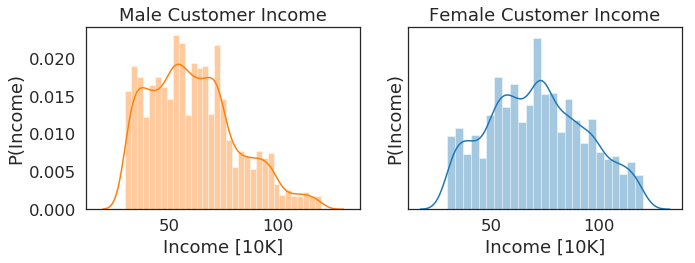

In [16]:
male_customers = profile[profile['gender'] == 1]
female_customers = profile[profile['gender'] == 0]

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

### Evaluate Membership Start Year Statistics
The results suggest that most customers recently joined the Starbucks rewards program. These results also suggest that there are more male customers than female customers.

Text(0, 0.5, 'Count')

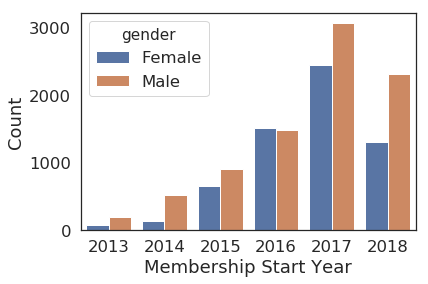

In [17]:
membership_date = initialize_membership_date(profile,
                                             gender_integer_map)

sns.barplot(x='startyear', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

#### Compute customer gender distribution

In [18]:
membership_date.groupby('gender')['count'].sum()

gender
Female    6129
Male      8484
Name: count, dtype: int64

### Evaluate Age Range Statistics  
These results suggest that the average customer age is between 50 and 60 years old.  
- [Rotate axis text in Python matplotlib](https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib)  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

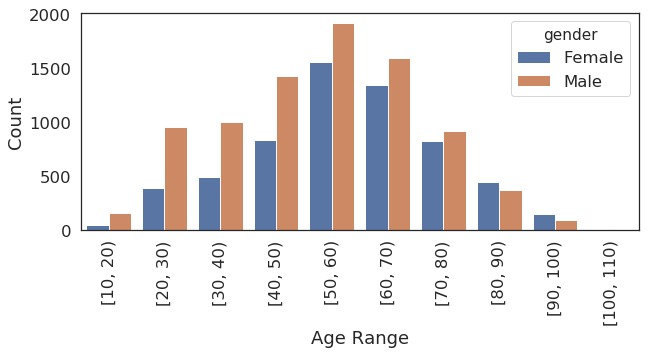

In [19]:
age_range = init_agerange(profile,
                          gender_integer_map)

plt.figure(figsize=(10, 4))
sns.barplot(x='agerange', y='count', hue='gender', data=age_range)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

### Transaction data EDA
- Customer transaction record attributes
    * event (str) - Record description (i.e. transaction, offer received, offer viewed, etc.)
    * person (str) - Customer id
    * time (int) - Time in hours. The data begins at time t=0
    * value - (dict of strings) - Either an offer id or transaction amount depending on the record
- Customer transaction data EDA conclusions  
    - Need to separate offer and customer purchase data  
    - Results suggest ~ 45 % of the events are customers purchases and ~ 55% of the events describe customer offers  

#### Print the first five rows of the transaction data

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


#### Compute the event type distribution

In [21]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


#### Compute the percentage of customer transaction and offer events

In [22]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


### Clean the transaction data  
1. Change the name of the 'person' column to 'customerid'  
2. Remove customer id's that are not in the customer profile DataFrame  
3. Convert time variable units from hours to days  
4. Change the name of the 'time' column to 'timedays'  
5. Create a DataFrame that describes offers  
    - Create an offerid column
    - Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
    - One hot encode customer offer events 
6. Create a DataFrame that describes customer transaction events
    - Parse customer transaction values  

In [23]:
offer_data, transaction = clean_transcript(profile)

Percentage of transactions removed: 12.31 %


#### Print the first five rows of the transformed customer offer data

In [24]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


#### Print the first five rows of the transformed customer transaction data

In [25]:
transaction.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


### Combine transaction, demographic and offer data 
For each customer, apply the following algorithm:
1. Select a customer's profile  
2. Select offer data for a specific customer
3. Select transactions for a specific customer
4. Initialize DataFrames that describe when a customer receives, views, and completes an offer
5. Iterate over each offer a customer receives
    - Initialize the current offer id  
    - Look-up a description of the current offer  
    - Initialize the time period when an offer is valid
    - Initialize a Boolean array that select customer transactions that fall within the valid offer time window
    - Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)  
    - Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
    - Determine whether the current offer was successful
        - For an offer to be successful a customer has to view and complete it  
    - Select customer transactions that occurred within the current offer valid time window  
    - Initialize a dictionary that describes the current customer offer  
    - Update a list of dictionaries that describes the effectiveness of offers to a specific customer
   
Once all customer transactions have been evaluated, convert the resulting list of dictionaries into a pandas DataFrame.

In [26]:
clean_data_csvfile = "./data/clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile,
                                              portfolio,
                                              offer_data,
                                              transaction)

    clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

,offerid,totalamount,offersuccessful,difficulty,durationdays,reward,bogo,discount,mobile,social,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,10,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,2,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


### Split the data into training and testing data
-[Training / test data percentages rule of thumb](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio)  

In [27]:
random_state = 3154220327

class_label_name = 'offersuccessful'

variables = clean_data.drop(columns=[class_label_name])
class_label = clean_data.filter([class_label_name])

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.2,
                            random_state=random_state)

variable_names = variables.columns[2:]

offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

#### Print offer effectiveness data attributes

In [28]:
print(variable_names)

Index(['difficulty', 'durationdays', 'reward', 'bogo', 'discount', 'mobile',
       'social', 'web', 'gender', 'income', '2013', '2014', '2015', '2016',
       '2017', '2018', '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)',
       '[100, 110)'],
      dtype='object')


#### Initialize a DataFrame that describes the training data (customer data only)

In [29]:
training_variables = pd.DataFrame(X_train, columns=variable_names)
training_labels = pd.DataFrame(y_train, columns=[class_label_name])
training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

training_data = pd.concat([training_offerid,
                           training_variables,
                           training_labels], axis=1)

training_data = training_data.drop(columns=['difficulty',
                                            'durationdays',
                                            'reward',
                                            'bogo',
                                            'discount',
                                            'mobile',
                                            'social',
                                            'web'])

training_data.head()

,offerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)",offersuccessful
0,f19421c1d4aa40978ebb69ca19b0e20d,1.0,36000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,ae264e3637204a6fb9bb56bc8210ddfd,0.0,110000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,0.0,114000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,fafdcd668e3743c1bb461111dcafc2a4,0.0,67000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,31000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Analyze Offer Statistics  
These results suggest that distribution of offers in the simulated Starbucks mobile application data is approximately uniform. They also imply that the percentage of an offer's success ranges from ~ 6% to 75%, with the two least successful offers being informational.   

In [30]:
percent_success = initialize_percent_success(portfolio,
                                             training_data)
percent_success

,offerid,count,percentsuccess,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,fafdcd668e3743c1bb461111dcafc2a4,5223,75.090944,10,10,2,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5259,72.485263,7,7,3,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,5203,61.925812,5,5,5,1,0,0,1,1,1,1
3,ae264e3637204a6fb9bb56bc8210ddfd,5312,54.725151,10,7,10,1,0,0,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,5172,51.798144,10,5,10,1,0,0,1,1,1,1
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5247,48.275205,5,7,5,1,0,0,1,1,0,1
6,2906b810c7d4411798c6938adc9daaa5,5238,47.098129,10,7,2,0,1,0,1,1,0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,5330,45.816135,20,10,5,0,1,0,1,0,0,1
8,3f207df678b143eea3cee63160fa8bed,5256,7.800609,0,4,0,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,5228,6.006121,0,3,0,0,0,1,1,1,1,0


#### Generate a plot that illustrates:
- How many customers were provided a specific offer
- Offer sucess rate (percentsuccess)

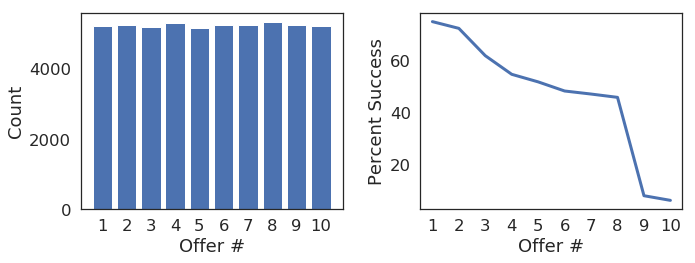

In [31]:
f, ax = plt.subplots(figsize=(10, 4),
                     nrows=1,
                     ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer #')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1,
           percent_success['percentsuccess'],
           linewidth=3)
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer #')
ax[1].set_ylabel('Percent Success')
plt.tight_layout()

## Transform variables
- Dataset includes both numeric and one hot encoded categorical variables
    - Apply minimum / maximum scaling to numeric variables to avoid model bias  
        - [The use of feature scaling in scikit learn](https://stackoverflow.com/questions/51660001/the-use-of-feature-scaling-in-scikit-learn)  

In [32]:
variables_to_scale = ['difficulty', 'durationdays', 'reward', 'income']

min_max_scaler = {}

for idx in range(len(variables_to_scale)):
    column_idx = np.argwhere(variable_names == variables_to_scale[idx])[0, 0]
    
    cur_column = variables_to_scale[idx]
    
    min_max_scaler[cur_column] = MinMaxScaler()
    min_max_scaler[cur_column].fit(X_train[:, column_idx].reshape(-1, 1))

    transformed_values =\
        min_max_scaler[cur_column].transform(X_train[:, column_idx].reshape(-1, 1))

    X_train[:, column_idx] = transformed_values.reshape(1, -1)
    
    transformed_values =\
        min_max_scaler[cur_column].transform(X_test[:, column_idx].reshape(-1, 1))

    X_test[:, column_idx] = transformed_values.reshape(1, -1)

### Analyze Customer Statistics
- General trends
    - Offer success increases with average customer income and age
    - For unsuccessful offers the percentage of male customers is typically significantly higher than the percentage of female customers  
    - Offers are less successful for customers who created an account on the Starbucks rewards mobile application in 2018 (membership start year)   

#### offerid: fafdcd668e3743c1bb461111dcafc2a4
- Offer successful  
    - Average customer income: 65902.5
    - Average customer age: 55.7 years
    - Percentage of male customers: 55.1%
    - Percentage of female customers: 44.9%
    - Earlier membership start year more likely
- Offer unsuccessful
    - Average customer income: 58136.2
    - Average customer age: 52.6 years
    - Percentage of male customers: 69.8%
    - Percentage of female customers: 30.2%
    - Later membership start year more likely

offerid: fafdcd668e3743c1bb461111dcafc2a4
Offer successful
	Average customer income: $65902.5
	Average customer age: 55.7 [years]
Offer unsuccessful
	Average customer income: $58136.2
	Average customer age: 52.6 [years]
   gender  percentage successful
0    Male   55.124936        Yes
1  Female   44.875064        Yes
2    Male   69.792467         No
3  Female   30.207533         No
    membershipstartyear  percentage successful
0                  2013    2.269250        Yes
6                  2013    0.538048         No
1                  2014    5.379908        Yes
7                  2014    2.613374         No
2                  2015   13.488016        Yes
8                  2015    2.075327         No
3                  2016   26.185620        Yes
9                  2016    2.690238         No
4                  2017   35.900051        Yes
10                 2017   40.737894         No
5                  2018   16.777155        Yes
11                 2018   51.345119         No


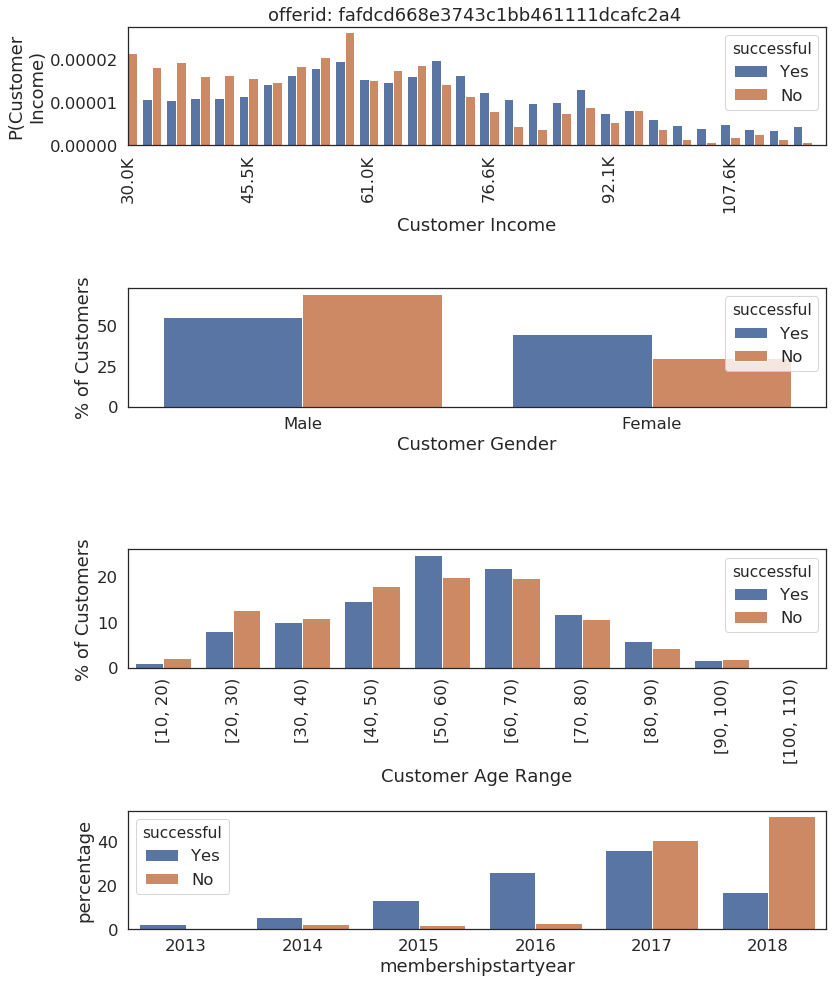

In [33]:
explore_customer_offer(0, percent_success, training_data, gender_integer_map)

#### offerid: 2298d6c36e964ae4a3e7e9706d1fb8c2
- Offer successful  
    - Average customer income: 65467.4  
    - Average customer age: 55.1 years  
    - Percentage of male customers: 54.3%  
    - Percentage of female customers: 45.7%  
    - Earlier membership start year more likely
- Offer unsuccessful  
    - Average customer income: 58825.4  
    - Average customer age: 52.9 years  
    - Percentage of male customers: 70.1%  
    - Percentage of female customers: 29.9%  
    - Later membership start year more likely

offerid: 2298d6c36e964ae4a3e7e9706d1fb8c2
Offer successful
	Average customer income: $65467.4
	Average customer age: 55.1 [years]
Offer unsuccessful
	Average customer income: $58825.4
	Average customer age: 52.9 [years]
   gender  percentage successful
0    Male   54.302204        Yes
1  Female   45.697796        Yes
2    Male   70.076019         No
3  Female   29.923981         No
    membershipstartyear  percentage successful
0                  2013    2.177335        Yes
6                  2013    0.760194         No
1                  2014    5.351522        Yes
7                  2014    2.418798         No
2                  2015   11.909759        Yes
8                  2015    3.593642         No
3                  2016   26.049318        Yes
9                  2016    5.321355         No
4                  2017   37.303253        Yes
10                 2017   40.290256         No
5                  2018   17.208814        Yes
11                 2018   47.615757         No


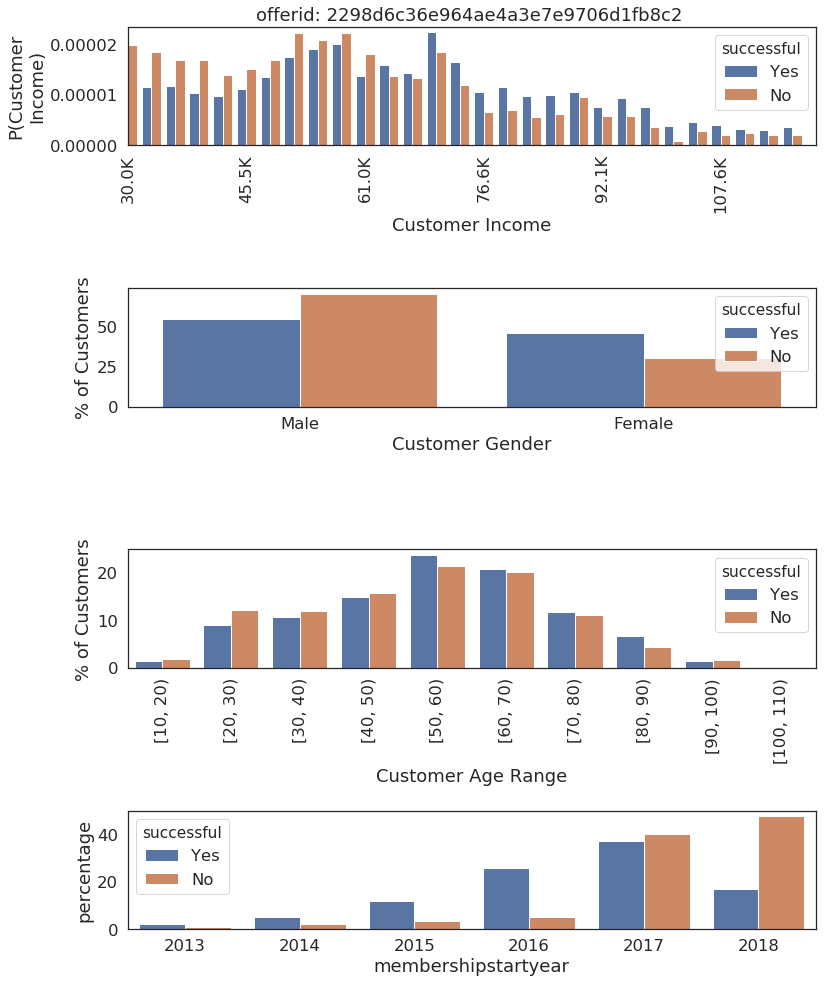

In [34]:
explore_customer_offer(1, percent_success, training_data, gender_integer_map)

#### offerid: f19421c1d4aa40978ebb69ca19b0e20d
- Offer successful
    - Average customer income: 67245.2
    - Average customer age: 56.3 years
    - Percentage of male customers: 53.3%
    - Percentage of female customers: 46.7%
    - Higher percentage of 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 58993.2
    - Average customer age: 53.3 years
    - Percentage of male customers: 65.9%
    - Percentage of female customers: 34.1%
    - Higher percentage of 2018 membership start year

offerid: f19421c1d4aa40978ebb69ca19b0e20d
Offer successful
	Average customer income: $67245.2
	Average customer age: 56.3 [years]
Offer unsuccessful
	Average customer income: $58993.2
	Average customer age: 53.3 [years]
   gender  percentage successful
0    Male   53.538175        Yes
1  Female   46.461825        Yes
2    Male   65.926300         No
3  Female   34.073700         No
    membershipstartyear  percentage successful
0                  2013    1.613904        Yes
6                  2013    2.069662         No
1                  2014    4.034761        Yes
7                  2014    4.391721         No
2                  2015   12.166356        Yes
8                  2015    6.309944         No
3                  2016   28.181254        Yes
9                  2016    8.278647         No
4                  2017   38.578523        Yes
10                 2017   40.080767         No
5                  2018   15.425202        Yes
11                 2018   38.869258         No


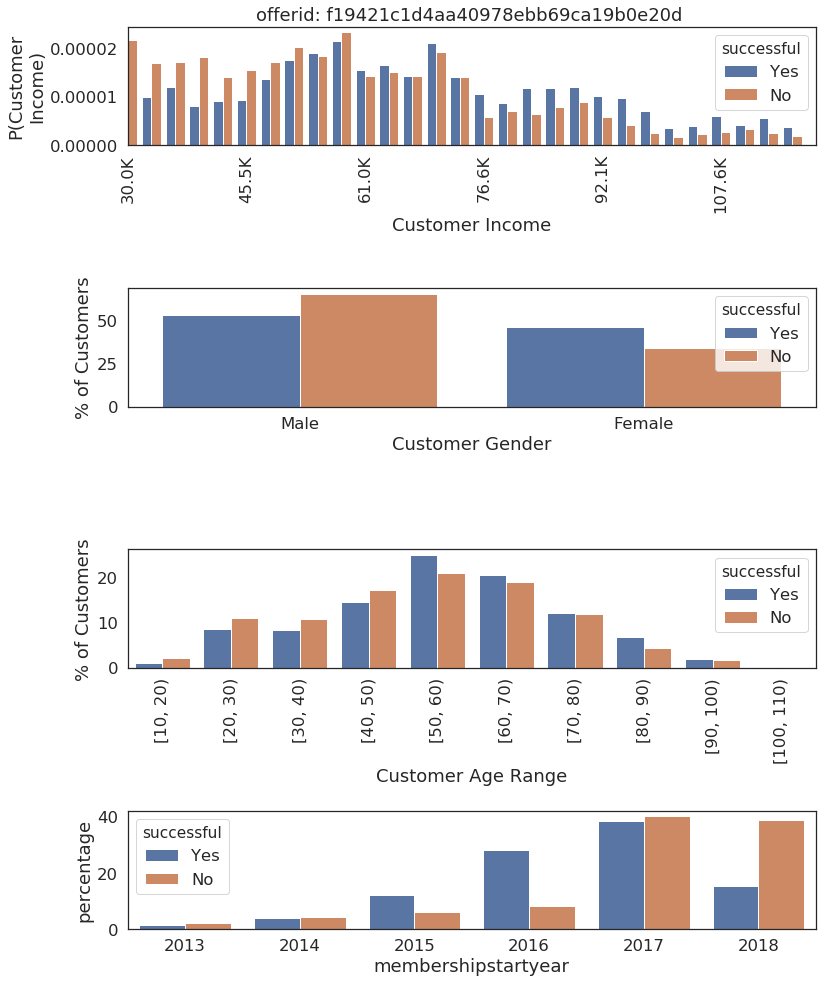

In [35]:
explore_customer_offer(2, percent_success, training_data, gender_integer_map)

#### offerid: ae264e3637204a6fb9bb56bc8210ddfd
- Offer successful
    - Average customer income: 68311.1
    - Average customer age: 56.0 years
    - Percentage of male customers: 50.9%
    - Percentage of female customers: 49.1%
    - Higher percentage of 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 59013.7
    - Average customer age: 52.5 years
    - Percentage of male customers: 67.5%
    - Percentage of female customers: 32.5%
    - Higher percentage of 2018 membership start year

offerid: ae264e3637204a6fb9bb56bc8210ddfd
Offer successful
	Average customer income: $68311.1
	Average customer age: 56.0 [years]
Offer unsuccessful
	Average customer income: $59013.7
	Average customer age: 52.5 [years]
   gender  percentage successful
0    Male   50.877193        Yes
1  Female   49.122807        Yes
2    Male   67.525988         No
3  Female   32.474012         No
    membershipstartyear  percentage successful
0                  2013    1.203990        Yes
6                  2013    2.952183         No
1                  2014    3.130375        Yes
7                  2014    5.862786         No
2                  2015   13.622291        Yes
8                  2015    8.357588         No
3                  2016   28.207774        Yes
9                  2016   10.769231         No
4                  2017   37.048504        Yes
10                 2017   37.796258         No
5                  2018   16.787066        Yes
11                 2018   34.261954         No


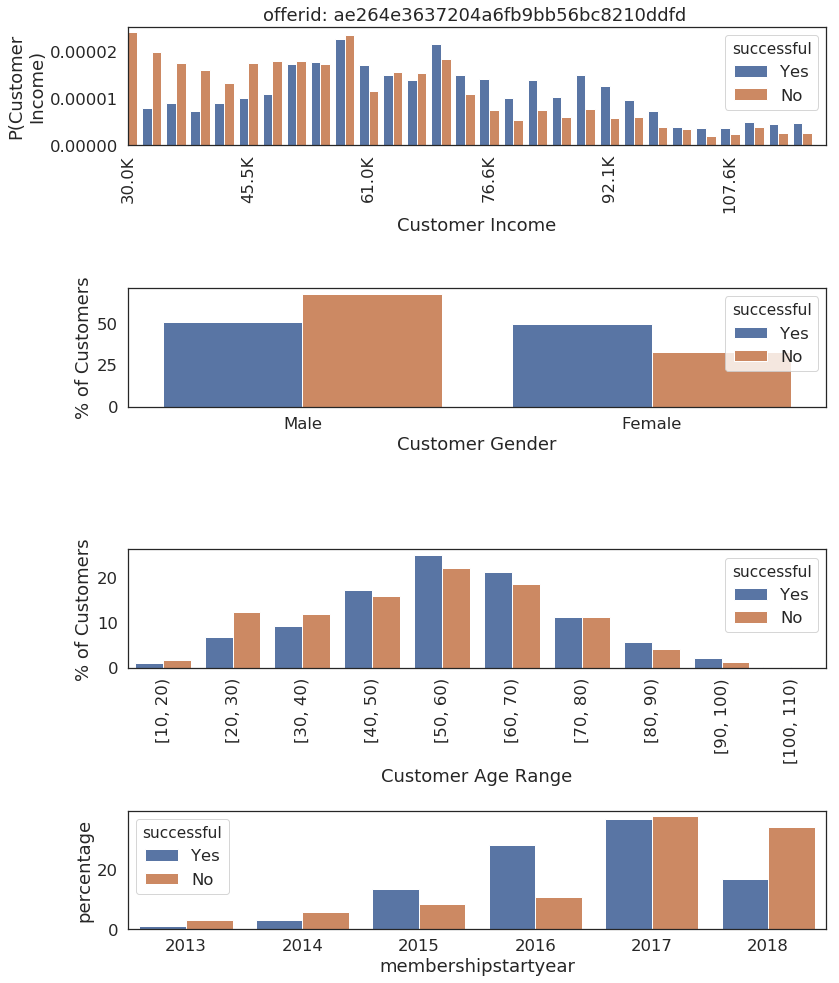

In [36]:
explore_customer_offer(3, percent_success, training_data, gender_integer_map)

#### offerid: 4d5c57ea9a6940dd891ad53e9dbe8da0
- Offer successful
    - Average customer income: 70222.0
    - Average customer age: 56.8 years
    - Percentage of male customers: 48%
    - Percentage of female customers: 52%
    - Higher percentage of 2014, 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 57787.9
    - Average customer age: 52.6 years
    - Percentage of male customers: 68.6%
    - Percentage of female customers: 31.4%
    - Higher percentage of 2018 membership start year

offerid: 4d5c57ea9a6940dd891ad53e9dbe8da0
Offer successful
	Average customer income: $70222.0
	Average customer age: 56.8 [years]
Offer unsuccessful
	Average customer income: $57787.9
	Average customer age: 52.6 [years]
   gender  percentage successful
0  Female   51.997014        Yes
1    Male   48.002986        Yes
2    Male   68.592058         No
3  Female   31.407942         No
    membershipstartyear  percentage successful
0                  2013    1.455767        Yes
6                  2013    2.326514         No
1                  2014    3.359462        Yes
7                  2014    6.377858         No
2                  2015   13.064576        Yes
8                  2015    7.621340         No
3                  2016   28.779395        Yes
9                  2016   11.432010         No
4                  2017   39.492348        Yes
10                 2017   37.785800         No
5                  2018   13.848451        Yes
11                 2018   34.456478         No


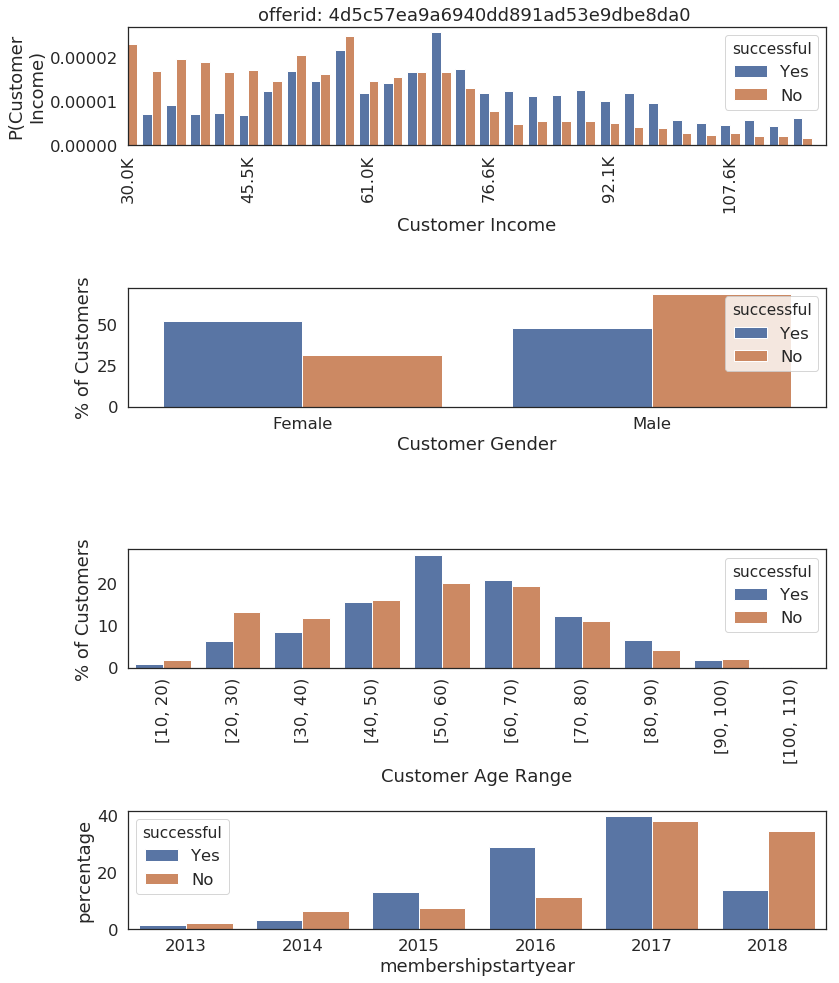

In [37]:
explore_customer_offer(4, percent_success, training_data, gender_integer_map)

#### offerid: 9b98b8c7a33c4b65b9aebfe6a799e6d9
- Offer successful
    - Average customer income: 66242.8
    - Average customer age: 56.0 years
    - Percentage of male customers: 53%
    - Percentage of female customers: 47%
    - Higher percentage of 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 60914.4
    - Average customer age: 54.0 years
    - Percentage of male customers: 63.4%
    - Percentage of female customers: 36.6%
    - Higher percentage of 2018 membership start year

offerid: 9b98b8c7a33c4b65b9aebfe6a799e6d9
Offer successful
	Average customer income: $66242.8
	Average customer age: 56.0 [years]
Offer unsuccessful
	Average customer income: $60914.4
	Average customer age: 54.0 [years]
   gender  percentage successful
0    Male   53.099092        Yes
1  Female   46.900908        Yes
2    Male   63.375092         No
3  Female   36.624908         No
    membershipstartyear  percentage successful
0                  2013    2.092381        Yes
6                  2013    1.989683         No
1                  2014    4.263719        Yes
7                  2014    3.979366         No
2                  2015   15.001974        Yes
8                  2015    9.322034         No
3                  2016   25.463877        Yes
9                  2016   15.438467         No
4                  2017   36.162653        Yes
10                 2017   37.730287         No
5                  2018   17.015397        Yes
11                 2018   31.540162         No


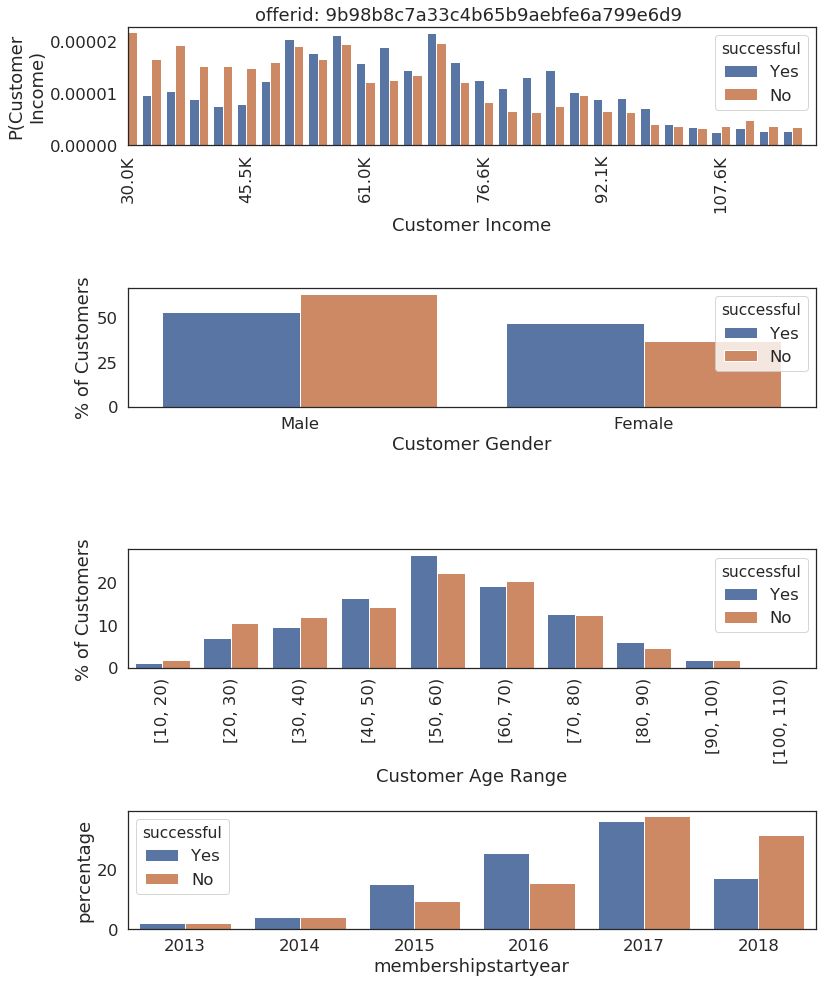

In [38]:
explore_customer_offer(5, percent_success, training_data, gender_integer_map)

#### offerid: 2906b810c7d4411798c6938adc9daaa5
- Offer successful
    - Average customer income: 67987.4
    - Average customer age: 56.3 years
    - Percentage of male customers: 53.5%
    - Percentage of female customers: 46.5%
    - Higher percentage of 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 60452.1
    - Average customer age: 53.1 years
    - Percentage of male customers: 63%
    - Percentage of female customers: 37%
    - Higher percentage of 2018 membership start year

offerid: 2906b810c7d4411798c6938adc9daaa5
Offer successful
	Average customer income: $67987.4
	Average customer age: 56.3 [years]
Offer unsuccessful
	Average customer income: $60452.1
	Average customer age: 53.1 [years]
   gender  percentage successful
0    Male   53.546818        Yes
1  Female   46.453182        Yes
2    Male   63.009744         No
3  Female   36.990256         No
    membershipstartyear  percentage successful
0                  2013    1.986218        Yes
6                  2013    1.660051         No
1                  2014    4.945278        Yes
7                  2014    3.464453         No
2                  2015   13.417106        Yes
8                  2015    9.310718         No
3                  2016   26.753141        Yes
9                  2016   14.543486         No
4                  2017   36.724767        Yes
10                 2017   37.892458         No
5                  2018   16.173490        Yes
11                 2018   33.128834         No


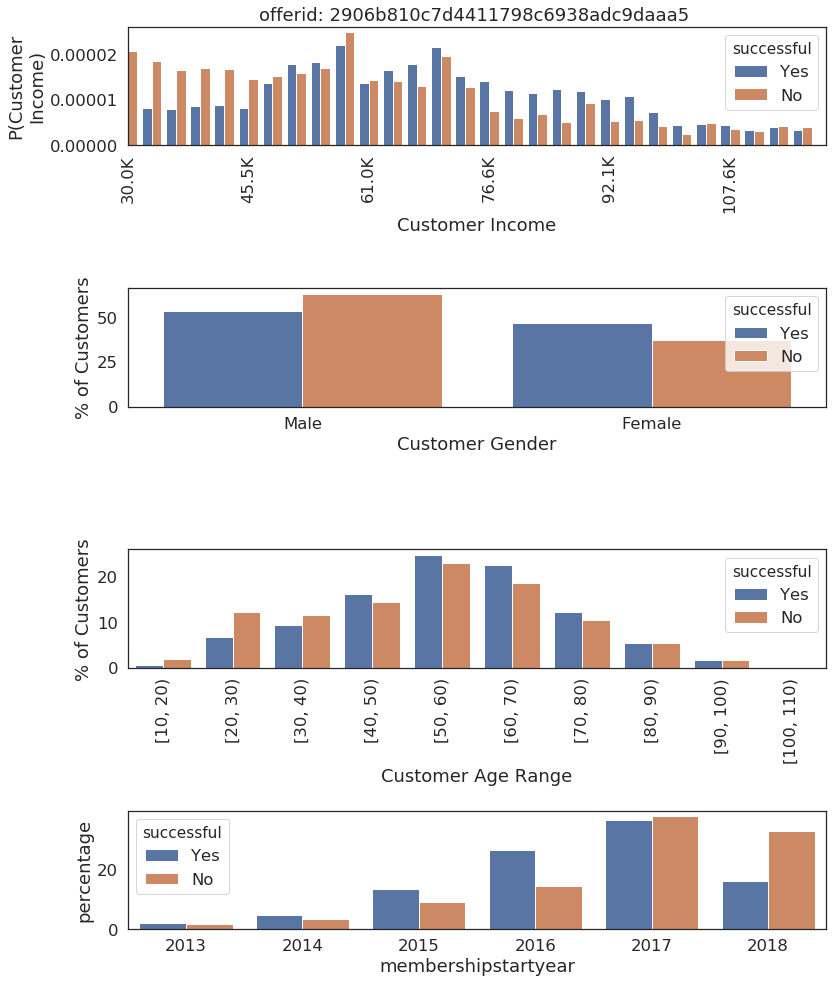

In [39]:
explore_customer_offer(6, percent_success, training_data, gender_integer_map)

#### offerid: 0b1e1539f2cc45b7b9fa7c272da2e1d7
- Offer successful
    - Average customer income: 67918.7
    - Average customer age: 56.3 years
    - Percentage of male customers: 52.4%
    - Percentage of female customers: 47.6%
    - Higher percentage of 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 60420.9
    - Average customer age: 53.9 years
    - Percentage of male customers: 62.3%
    - Percentage of female customers: 37.6%
    - Higher percentage of 2018 membership start year

offerid: 0b1e1539f2cc45b7b9fa7c272da2e1d7
Offer successful
	Average customer income: $67918.7
	Average customer age: 56.3 [years]
Offer unsuccessful
	Average customer income: $60420.9
	Average customer age: 53.9 [years]
   gender  percentage successful
0    Male   52.375102        Yes
1  Female   47.624898        Yes
2    Male   62.326870         No
3  Female   37.673130         No
    membershipstartyear  percentage successful
0                  2013    1.392301        Yes
6                  2013    1.904432         No
1                  2014    4.258804        Yes
7                  2014    4.397507         No
2                  2015   13.185913        Yes
8                  2015    9.349030         No
3                  2016   28.705979        Yes
9                  2016   14.508310         No
4                  2017   35.176085        Yes
10                 2017   37.984765         No
5                  2018   17.280917        Yes
11                 2018   31.855956         No


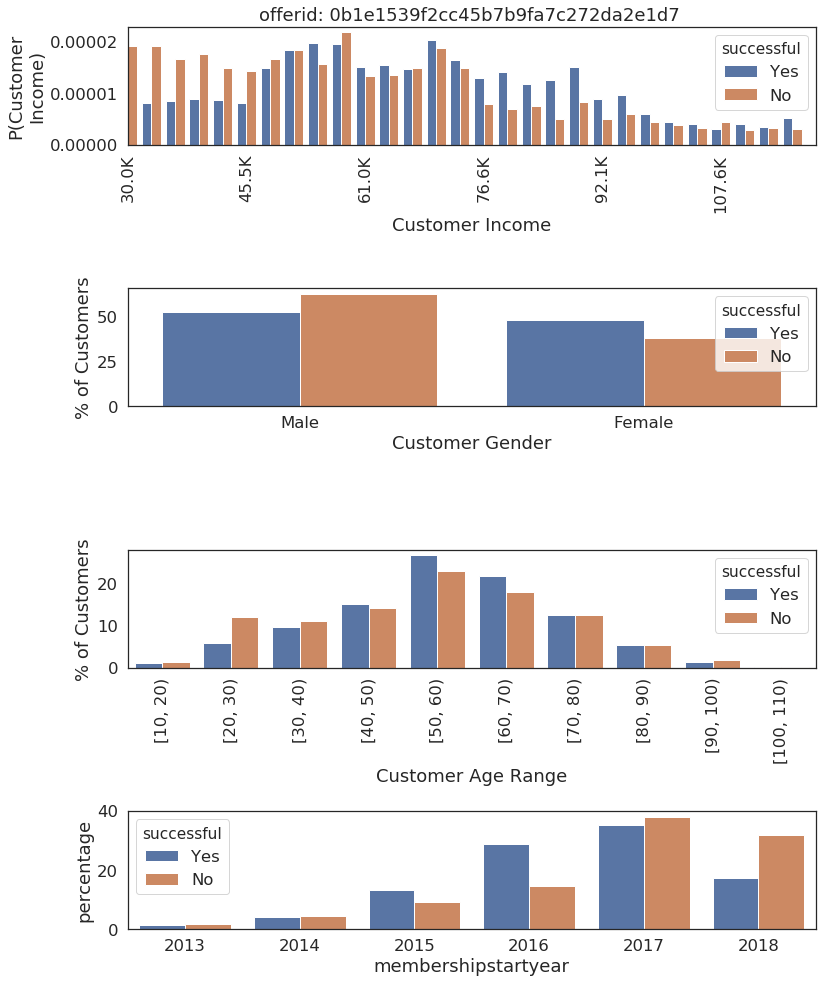

In [40]:
explore_customer_offer(7, percent_success, training_data, gender_integer_map)

#### offerid: 3f207df678b143eea3cee63160fa8bed
- Offer successful
    - Average customer income: 68936.9
    - Average customer age: 57.5 years
    - Percentage of male customers: 53.9%
    - Percentage of male customers: 46.1%
    - Higher percentage of 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 63243.9
    - Average customer age: 54.8 years
    - Percentage of male customers: 58%
    - Percentage of male customers: 42%
    - Higher percentage of 2018 membership start year

offerid: 3f207df678b143eea3cee63160fa8bed
Offer successful
	Average customer income: $68936.9
	Average customer age: 57.5 [years]
Offer unsuccessful
	Average customer income: $63243.9
	Average customer age: 54.8 [years]
   gender  percentage successful
0    Male   53.902439        Yes
1  Female   46.097561        Yes
2    Male   58.047875         No
3  Female   41.952125         No
    membershipstartyear  percentage successful
0                  2013    2.195122        Yes
6                  2013    2.001651         No
1                  2014    5.853659        Yes
7                  2014    4.622369         No
2                  2015   13.414634        Yes
8                  2015   10.235246         No
3                  2016   25.365854        Yes
9                  2016   19.913331         No
4                  2017   35.365854        Yes
10                 2017   37.969459         No
5                  2018   17.804878        Yes
11                 2018   25.257945         No


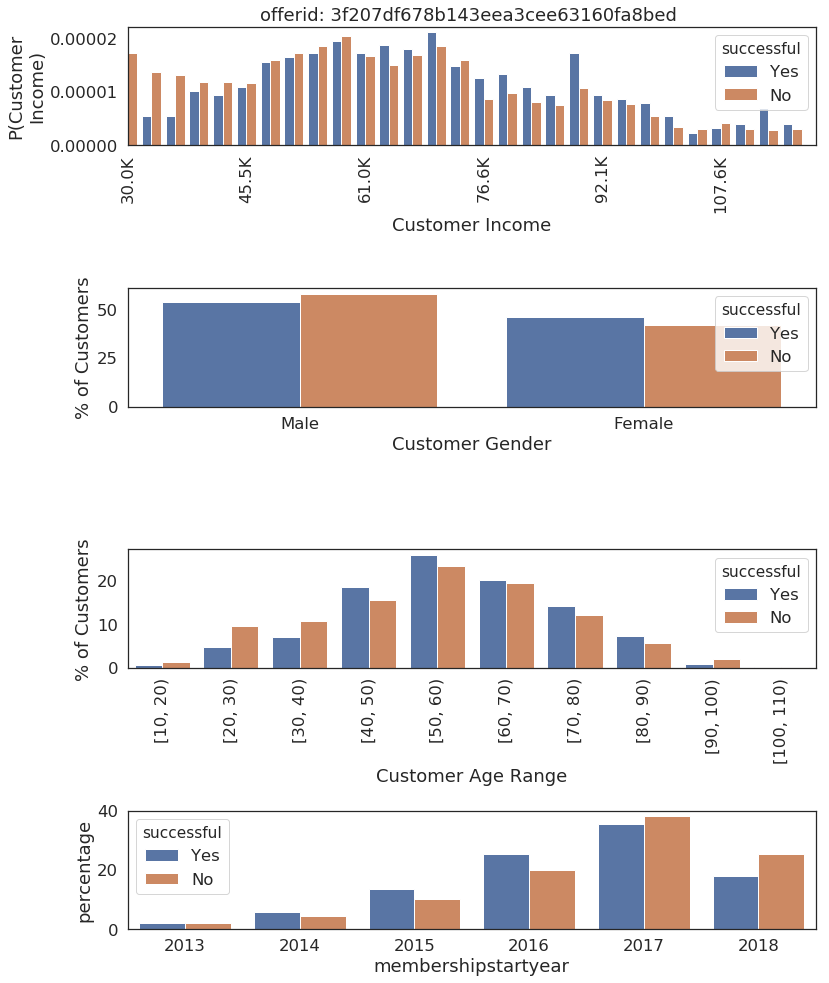

In [41]:
explore_customer_offer(8, percent_success, training_data, gender_integer_map)

#### offerid: 5a8bc65990b245e5a138643cd4eb9837
- Offer successful
    - Average customer income: 63772.2
    - Average customer age: 57.2 years
    - Percentage of male customers: 56.7%
    - Percentage of female customers: 43.3%
    - Higher percentage of 2014, 2015 & 2016 membership start years
- Offer unsuccessful
    - Average customer income: 63942.1
    - Average customer age: 55.2 years
    - Percentage of male customers: 57.5%
    - Percentage of female customers: 42.5%
    - Higher percentage of 2017 & 2018 membership start years

offerid: 5a8bc65990b245e5a138643cd4eb9837
Offer successful
	Average customer income: $63772.2
	Average customer age: 57.2 [years]
Offer unsuccessful
	Average customer income: $63942.1
	Average customer age: 55.2 [years]
   gender  percentage successful
0    Male   56.687898        Yes
1  Female   43.312102        Yes
2    Male   57.488807         No
3  Female   42.511193         No
    membershipstartyear  percentage successful
0                  2013    2.547771        Yes
6                  2013    1.750102         No
1                  2014    7.006369        Yes
7                  2014    4.395604         No
2                  2015   14.331210        Yes
8                  2015   10.317460         No
3                  2016   25.159236        Yes
9                  2016   20.370370         No
4                  2017   35.350318        Yes
10                 2017   39.072039         No
5                  2018   15.605096        Yes
11                 2018   24.094424         No


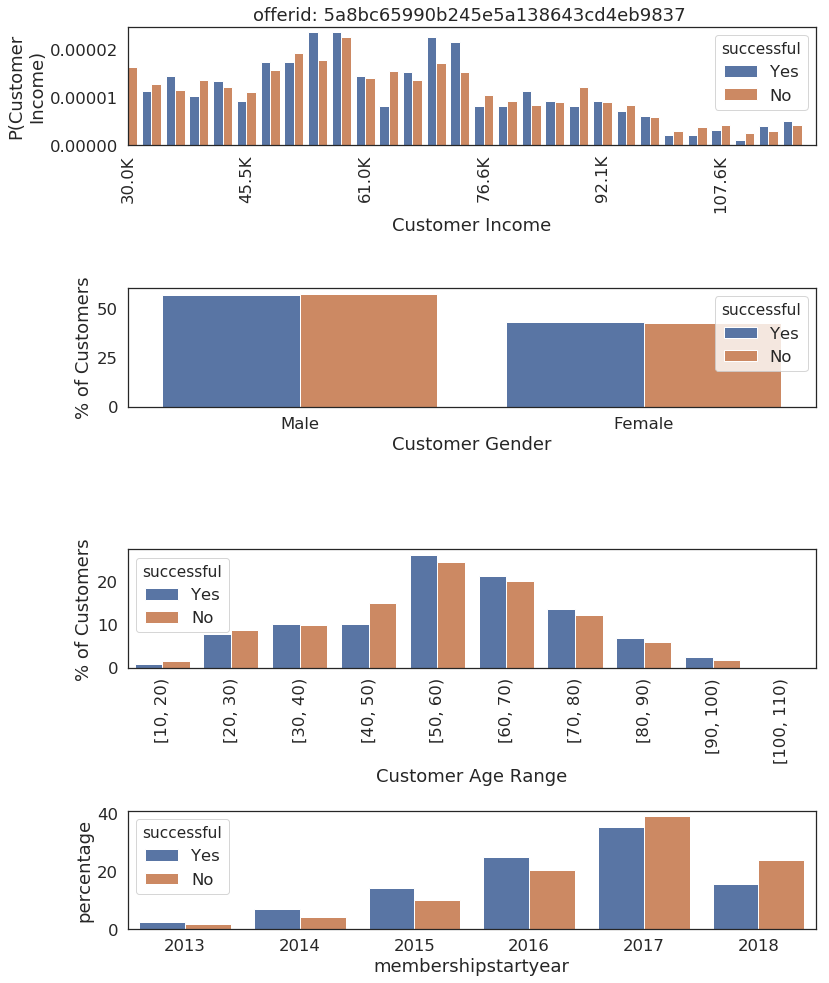

In [42]:
explore_customer_offer(9, percent_success, training_data, gender_integer_map)

## Predictive Modeling

## Evaluate [naive predictor](https://www.ritchieng.com/machine-learning-evaluate-classification-model/) performance
- A naive predictor assumes that all customer offers were successful

In [43]:
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.471
Naive predictor f1-score: 0.640


## Construct Logistic Regression model
- Perform random search of model hyperparameter space
    - [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)  
- Resuls suggest that a logistic regression model's accuracy and f1-score is better than the naive predictor
    - Accuracy
        - Naive predictor: 0.471
        - Logistic regression: 0.722
    - F1-score
        - Naive predictor: 0.640
        - Logistic regression: 0.716

In [44]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,
                     beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

#### Define model performance evaluation function

In [45]:
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

#### Evaluate Logistic Regression Model Performance

In [46]:
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.716


(0.7216779751467561, 0.7160661857634502)

### Construct Random Forest Model
- Perform random search of model hyperparameter space  
- Resuls suggest that a random forest model's accuracy and f1-score is better than the naive predictor
    - Accuracy
        - Naive predictor: 0.471
        - Random forest: 0.742
    - F1-score
        - Naive predictor: 0.640
        - Random forest: 0.735

In [47]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

#### Evalaute Random Forest Model Performance

In [48]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.742
RandomForestClassifier model f1-score: 0.735


(0.7421857131966151, 0.7354959816976594)

### Plot Estimated Feature Importance
- "[Feature importance](https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e)" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric   
- These results suggest that the top five features for this problem are:
    1. Offer difficulty (how much money a customer must spend to complete an offer)
    2. Offer duration
    3. Offer reward
    4. Customer income
    5. Whether a customer created an account on the Starbucks rewards mobile application in 2018  

Text(0.5, 1.0, 'Random Forest Estimated Feature Importance')

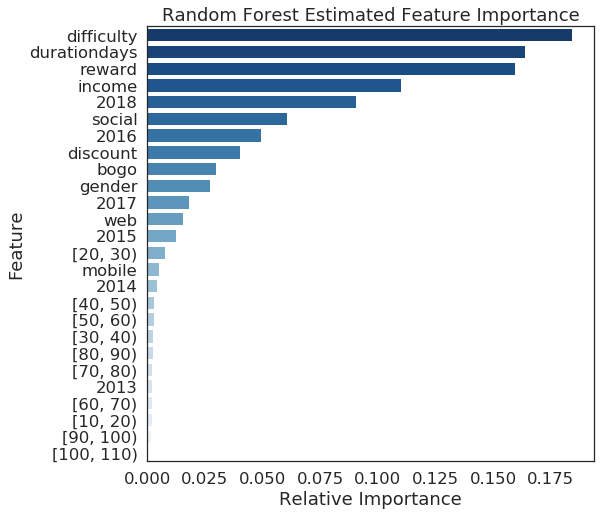

In [49]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

#### Print the top 10 features sorted based on their estimated importance

In [50]:
feature_importance.head(n=10)

,feature,relativeimportance
0,difficulty,0.184292
1,durationdays,0.163774
2,reward,0.159451
3,income,0.110082
4,2018,0.090656
5,social,0.060633
6,2016,0.049357
7,discount,0.040040
8,bogo,0.029970
9,gender,0.027357


### Construct a Gradient Boosting classifier
- Perform random search of model hyperparameter space  
- Resuls suggest that a gradient boosting model's accuracy and f1-score is better than the naive predictor
    - Accuracy
        - Naive predictor: 0.471
        - Gradient boosting: 0.736
    - F1-score
        - Naive predictor: 0.640
        - Gradient boosting: 0.725

In [51]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

if os.path.exists(gb_model_path):
    gb_random = load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

    gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    gb_random.fit(X_train, y_train)

    dump(gb_random, gb_model_path)

#### Evaluate Gradient Boosting Model Performance

In [52]:
evaluate_model_performance(gb_random.best_estimator_,
                           X_train,
                           y_train)

GradientBoostingClassifier model accuracy: 0.736
GradientBoostingClassifier model f1-score: 0.725


(0.7356102767401083, 0.7246854284920414)

### Tune the best model
- Model ranking based on training data accuracy
    1. RandomForestClassifier model accuracy: 0.742
    2. GradientBoostingClassifier model accuracy: 0.736
    3. LogisticRegression model accuracy: 0.722
    4. Naive predictor accuracy: 0.471
- Model ranking based on training data F1-score
    1. RandomForestClassifier model f1-score: 0.735
    2. GradientBoostingClassifier model f1-score: 0.725
    3. LogisticRegression model f1-score: 0.716
    4. Naive predictor f1-score: 0.640
- Results suggest that the random forest model has the best training data accuracy and F1-score  

[Bias and variance](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/) are two characteristics of a machine learning model. Bias refers to inherent model assumptions regarding the decision boundary between different classes. On the other hand, variance refers a model's sensitivity to changes in its inputs. 
A logistic regression model constructs a [linear decision boundary](https://datascience.stackexchange.com/questions/6048/decision-tree-or-logistic-regression) to separate successful and unsuccessful offers. However, my exploratory analysis of customer demographics for each offer suggests that this decision boundary will be non-linear. Therefore, an [ensemble method](https://datascience.stackexchange.com/questions/6048/decision-tree-or-logistic-regression) like random forest or gradient boosting should perform better.

Both [random forest](http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics) and gradient boosting models are a combination of multiple decision trees. A random forest classifier randomly samples the training data with replacement to construct a set of decision trees that are combined using [majority voting](http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics). In contrast, [gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/) iteratively constructs a set of decision trees with the goal of reducing the number of misclassified training data samples from the previous iteration. A consequence of these [model construction strategies](https://stats.stackexchange.com/questions/173390/gradient-boosting-tree-vs-random-forest) is that the depth of decision trees generated during random forest model training are typically greater than gradient boosting weak learner depth to minimize [model variance](https://stats.stackexchange.com/questions/173390/gradient-boosting-tree-vs-random-forest). Typically, gradient boosting performs better than a random forest classifier. However, gradient boosting may overfit the training data and requires additional effort to tune. A random forest classifier is less prone to overfitting because it constructs decision trees from random training data samples. Also, a random forest classifier's hyperparameters are easier to optimize (1).

(1) [How can the performance of a Gradient Boosting Machine be worse than Random -Forests](https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests).  

In [53]:
model_performance = []

classifier_type = ['naivepredictor',
                   'logisticregression',
                   'randomforest',
                   'gradientboosting']

model_performance.append((naive_predictor_accuracy,
                          naive_predictor_f1score))

model_performance.append(evaluate_model_performance(lr_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(rf_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(gb_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance = pd.DataFrame(model_performance,
                                 columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,
                               columns=['classifiertype'])

model_performance = pd.concat([classifier_type, model_performance],
                              axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

LogisticRegression model accuracy: 0.722
LogisticRegression model f1-score: 0.716
RandomForestClassifier model accuracy: 0.742
RandomForestClassifier model f1-score: 0.735
GradientBoostingClassifier model accuracy: 0.736
GradientBoostingClassifier model f1-score: 0.725


,classifiertype,accuracy,f1score
0,randomforest,0.742186,0.735496
1,gradientboosting,0.735610,0.724685
2,logisticregression,0.721678,0.716066
3,naivepredictor,0.470916,0.640303


#### Print the Best Model's Hyperparameters

In [54]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=3154220327, verbose=0,
            warm_start=False)


### Refine Best Model
- Refine model hyperparameter space
    - [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)  

In [55]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [300, 350, 400, 450, 500],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split,
                  'random_state': [random_state]}

    grid_obj = GridSearchCV(rf_clf,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=3,
                            verbose=2)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.753
RandomForestClassifier model f1-score: 0.746


(0.7527635892353435, 0.7455672367801663)

#### Print the Refined Random Forest Model's Hyperparameters

In [56]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=None,
            oob_score=False, random_state=3154220327, verbose=0,
            warm_start=False)

### Evaluate Test Data Performance

In [57]:
evaluate_model_performance(best_clf,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.736
RandomForestClassifier model f1-score: 0.727


(0.7356865136845315, 0.7267281469220461)

### Conclusion

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has four steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of a naive model that assumes all offers were successful. Third, I compared the performance of logistic regression, random forest, and gradient boosting models. This analysis suggests that a random forest model has the best training data accuracy and F1-score. Fourth, I refined random forest model hyperparameters using a grid search. My analysis suggests that the resulting random forest model has an training data accuracy of 0.753 and an F1-score of 0.746. 
The test data set accuracy of 0.736 and F1-score of 0.727 suggests that the random forest model I constructed did not [overfit the training data](https://elitedatascience.com/overfitting-in-machine-learning).  

"[Feature importance](https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e)" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. My analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top five features based on their importance are:  
  
    1. Offer difficulty (how much money a customer must spend to complete an offer)  
    2. Offer duration   
    3. Offer reward  
    4. Customer income  
    5. Whether a customer created an account on the Starbucks rewards mobile application in 2018  
    
Since the top three features are associated with an customer offer, it may be possible to improve the performance of a random forest model by creating features that describe an offer's success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.  